In [6]:
# ----------------------------------------- #
#                  MODULES                  #

# Standard Modules
import os
import warnings

# Third-Party Modules
import h3
import geopandas as gpd
import numpy as np
import pandas as pd
import plotly.express as px
import swifter

from pygam import LogisticGAM, s
from sklearn.metrics import average_precision_score, brier_score_loss, roc_auc_score
import pandas as pd
from sklearn.model_selection import GroupKFold
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
import pandas as pd
import numpy as np
import h3
import itertools
from pygam import LogisticGAM, s

#                                           #
# ----------------------------------------- #

In [2]:
# ----------------------------------------- #
#                 FUNCTIONS                 #


# Data Opener for Sightings Data
def open_sightings(path):
    if os.path.exists(path):
        if ".csv" in path:
            sightings = pd.read_csv(path)
            return sightings
        elif ".parquet" in path:
            sightings = pd.read_parquet(path)
            return sightings
        else:
            print("WARNING: Path is not a supported file type.")
    else:
        print("WARNING: Path does not exist.")


# Quick Preprocess on Read of Sightings Data
def quick_preprocess(data, h3_resolution):
    # Preprocess Sightings - Remove Spurious Data
    data["LONGITUDE"] = np.where(
        data["LONGITUDE"] > 0, data["LONGITUDE"] * -1, data["LONGITUDE"]
    )
    data = data[(data["LONGITUDE"] < -115) & (data["LONGITUDE"] > -160)]

    data = data.reset_index(drop=True)

    # Expand by COUNT
    # data = data.loc[data.index.repeat(data["COUNT"])].reset_index(drop=True)

    # Add H3 Cell Identity at Target Resolution
    data = data.assign(
        H3_CELL=lambda df: df.swifter.apply(
            lambda x: h3.latlng_to_cell(x["LATITUDE"], x["LONGITUDE"], h3_resolution),
            axis=1,
        )
    )

    # Covert Date Type
    data.DATE = pd.to_datetime(data.DATE)

    # Ensure POD-TYPE:POD-TAG Assignment is Aligned
    data["POD_TYPE"] = np.where(data["POD_TAG"] == "T", "TRANSIENT", data["POD_TYPE"])
    data["POD_TYPE"] = np.where(data["POD_TAG"] == "O", "OTHER", data["POD_TYPE"])
    data["POD_TYPE"] = np.where(
        data["POD_TAG"].isin(["J", "K", "L"]), "SRKW", data["POD_TYPE"]
    )
    data["POD_TYPE"] = np.where(
        ~data["POD_TAG"].isin(["J", "K", "L", "O", "T"]), "NRKW", data["POD_TYPE"]
    )

    # Define group blocks: H3_CELL + YEAR
    data["BLOCK"] = data["H3_CELL"].astype(str) + "_" + data["YEAR"].astype(str)

    return data


# Add Cyclical Features
def add_cyclical_features(df, cyclical_cols=None):
    """Add sin/cos transforms for cyclical temporal features."""
    if cyclical_cols is None:
        cyclical_cols = {
            "DOY": 365,
            "WOY": 52,
            "MONTH": 12,
        }

    for col, max_val in cyclical_cols.items():
        df[f"{col}_SIN"] = np.sin(2 * np.pi * df[col] / max_val)
        df[f"{col}_COS"] = np.cos(2 * np.pi * df[col] / max_val)
    return df


# Filter to Classed and Unclassed Sightings Data
def split_data_by_categorization_other(sightings_data):
    # 1. Filter to "OTHER" Sightings
    sightings_data_class = sightings_data[
        sightings_data["POD_TYPE"].isin(["SRKW", "NRKW", "TRANSIENT"])
    ].copy()

    # 2. Filter to "OTHER" Sightings
    sightings_data_other = sightings_data[
        ((sightings_data.POD_TYPE == "OTHER") | (sightings_data.POD_TYPE.isna()))
    ].copy()

    return sightings_data_class, sightings_data_other


#                                           #
# ----------------------------------------- #

In [ ]:
# Parameters
SIGHTINGS_PATH = (
    "../../data/processed/ORCA_SIGHTINGS/ORCA_SIGHTINGS.parquet"  # Data Paths
)
H3_RESOLTION = 6

In [4]:
################################################################################
# PREPARE DATA

# 1. Open Sightings Data
sightings_data_raw = open_sightings(SIGHTINGS_PATH)

# 2. Preprocess Sightings Data
sightings_data_raw = quick_preprocess(
    data=sightings_data_raw, h3_resolution=H3_RESOLTION
)

# 3. Add Cyclical Feature
sightings_data_raw = add_cyclical_features(sightings_data_raw)

# 4. Split Data Into Correctly Classified + Missing Classification
sightings_data_class, sightings_data_other = split_data_by_categorization_other(
    sightings_data=sightings_data_raw
)

################################################################################

Pandas Apply:   0%|          | 0/132227 [00:00<?, ?it/s]

In [5]:
sightings_data_class.columns

Index(['DATE', 'LATITUDE', 'LONGITUDE', 'POD_TYPE', 'POD_TAG', 'COUNT',
       'SOURCE', 'DATETIME', 'DOY', 'WOY', 'MONTH', 'YEAR', 'YEAR_WEEK',
       'YEAR_MONTH', 'STAT_WEEK_SUNDAY', 'H3_CELL', 'BLOCK', 'DOY_SIN',
       'DOY_COS', 'WOY_SIN', 'WOY_COS', 'MONTH_SIN', 'MONTH_COS'],
      dtype='object')

## GAM Started Model

In [53]:
def generate_pseudo_absences(
    df, h3_cells=None, weeks=None, max_ratio=2, random_state=42
):
    """
    df: sightings dataframe with 'YEAR_WEEK', 'H3_CELL', 'COUNT'
    h3_cells: optional list of all possible H3 cells
    weeks: optional list of all weeks
    max_ratio: maximum number of pseudo-absences per presence
    """
    np.random.seed(random_state)

    # Step 0: set presences
    df = df.copy()
    df["orca_present"] = 1

    # unique H3/week
    if h3_cells is None:
        h3_cells = df["H3_CELL"].unique()
    if weeks is None:
        weeks = df["YEAR_WEEK"].unique()

    # full grid
    full_space = pd.DataFrame(
        list(itertools.product(weeks, h3_cells)), columns=["YEAR_WEEK", "H3_CELL"]
    )

    # merge observed presences
    merged = full_space.merge(
        df[["YEAR_WEEK", "H3_CELL", "orca_present"]],
        on=["YEAR_WEEK", "H3_CELL"],
        how="left",
    )

    # pseudo-absence = 0
    merged["orca_present"] = merged["orca_present"].fillna(0)

    # subsample pseudo-absences if too many
    n_pres = merged["orca_present"].sum()
    pseudo_abs = merged[merged["orca_present"] == 0]
    max_abs = int(max_ratio * n_pres)
    if len(pseudo_abs) > max_abs:
        pseudo_abs = pseudo_abs.sample(max_abs, random_state=random_state)
    pres = merged[merged["orca_present"] == 1]

    merged_balanced = pd.concat([pres, pseudo_abs], ignore_index=True)

    return merged_balanced


def add_gam_covariates(df):
    df = df.copy()

    # H3 centroids
    def h3_to_latlon(h):
        lat, lon = h3.cell_to_latlng(h)
        return pd.Series({"LATITUDE": lat, "LONGITUDE": lon})

    centroids = df[["H3_CELL"]].drop_duplicates()
    centroids[["LATITUDE", "LONGITUDE"]] = centroids["H3_CELL"].apply(h3_to_latlon)
    df = pd.merge(df, centroids, on="H3_CELL", how="left")

    # Temporal features
    # YEAR_WEEK assumed "YYYY-WW" or "YYYY-MM"
    parts = df["YEAR_WEEK"].str.split("-", expand=True)
    df["YEAR_INT"] = parts[0].astype(int)
    df["WEEK_OR_MONTH"] = parts[1].astype(int)

    # approximate DOY
    df["DOY"] = (df["WEEK_OR_MONTH"] - 1) * 7
    df["MONTH"] = ((df["DOY"] / 30).astype(int) + 1).clip(1, 12)

    # sin/cos transforms
    df["DOY_SIN"] = np.sin(2 * np.pi * df["DOY"] / 365)
    df["DOY_COS"] = np.cos(2 * np.pi * df["DOY"] / 365)
    df["MONTH_SIN"] = np.sin(2 * np.pi * df["MONTH"] / 12)
    df["MONTH_COS"] = np.cos(2 * np.pi * df["MONTH"] / 12)

    # Define group blocks: H3_CELL + YEAR
    df["BLOCK"] = df["H3_CELL"].astype(str) + "_" + df["YEAR_INT"].astype(str)

    return df


from pygam import LogisticGAM, s
from sklearn.model_selection import GroupKFold
from sklearn.isotonic import IsotonicRegression
import numpy as np
import pandas as pd


def fit_gam_blocked_cv(df, groups, n_splits=5):
    """
    Fit a LogisticGAM with blocked spatiotemporal CV and isotonic recalibration.

    Parameters:
    -----------
    df : pd.DataFrame
        Must include 'LATITUDE','LONGITUDE','DOY_SIN','DOY_COS','MONTH_SIN','MONTH_COS',
        'orca_present','YEAR_WEEK'
    groups : array-like
        Grouping variable for blocked CV (e.g., H3_PARENT or YEAR_WEEK)
    n_splits : int
        Number of CV folds

    Returns:
    --------
    gam : fitted LogisticGAM on full dataset
    df : original df with 'proba_gam' column (calibrated)
    cv_results : pd.DataFrame with 'YEAR_WEEK','y_true','y_pred','fold' (calibrated)
    """
    X = df[
        ["LATITUDE", "LONGITUDE", "DOY_SIN", "DOY_COS", "MONTH_SIN", "MONTH_COS"]
    ].values
    y = df["orca_present"].values

    gkf = GroupKFold(n_splits=n_splits)
    results = []

    # Preallocate array for recalibrated probabilities
    y_prob_cal_all = np.zeros_like(y, dtype=float)

    for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        test_weeks = df.iloc[test_idx]["YEAR_WEEK"]

        # Fit GAM on training fold
        gam_fold = LogisticGAM(
            s(0, n_splines=15) + s(1, n_splines=15) + s(2) + s(3) + s(4) + s(5)
        ).fit(X_train, y_train)

        # Predict probabilities on test fold
        y_prob_test = gam_fold.predict_proba(X_test)

        # Fit isotonic regression on training fold predictions
        ir = IsotonicRegression(out_of_bounds="clip")
        ir.fit(gam_fold.predict_proba(X_train), y_train)

        # Recalibrate test fold probabilities
        y_pred_cal = ir.transform(y_prob_test)
        y_prob_cal_all[test_idx] = y_pred_cal

        # Store CV fold results
        fold_df = pd.DataFrame(
            {
                "YEAR_WEEK": test_weeks,
                "y_true": y_test,
                "y_pred": y_pred_cal,
                "fold": fold,
            }
        )
        results.append(fold_df)

    cv_results = pd.concat(results, ignore_index=True)

    # Fit GAM on full dataset
    gam = LogisticGAM(
        s(0, n_splines=15) + s(1, n_splines=15) + s(2) + s(3) + s(4) + s(5)
    ).fit(X, y)

    # Fit isotonic on full dataset for final calibrated probabilities
    ir_full = IsotonicRegression(out_of_bounds="clip")
    ir_full.fit(gam.predict_proba(X), y)
    df["proba_gam"] = ir_full.transform(gam.predict_proba(X))

    return gam, df, cv_results


def aggregate_weekly(df):
    weekly = df.groupby(["YEAR_WEEK", "H3_CELL"], as_index=False).agg(
        proba_mean=("proba_gam", "mean"),
        presence_obs=("orca_present", "max"),
        n_reports=("orca_present", "size"),
    )
    return weekly


def gam_performance_report(
    df, proba_col="proba_mean", presence_col="presence_obs", plot_calibration=True
):
    """
    df: dataframe with predictions and true labels
    proba_col: column with predicted probabilities
    presence_col: column with 0/1 labels
    plot_calibration: whether to produce calibration plot

    Returns: dict with global metrics
    """
    # global metrics
    y_true = df[presence_col]
    y_pred = df[proba_col]

    roc = roc_auc_score(y_true, y_pred) if len(set(y_true)) > 1 else float("nan")
    pr_auc = average_precision_score(y_true, y_pred)
    brier = brier_score_loss(y_true, y_pred)

    metrics = {"ROC_AUC": roc, "PR_AUC": pr_auc, "Brier": brier}

    # calibration curve
    if plot_calibration:
        prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)
        plt.figure(figsize=(6, 6))
        plt.plot(prob_pred, prob_true, marker="o", label="Model")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect")
        plt.xlabel("Predicted probability")
        plt.ylabel("Observed frequency")
        plt.title("Calibration Curve")
        plt.legend()
        plt.show()

    return metrics

In [54]:
df = sightings_data_class[sightings_data_class.POD_TYPE == "SRKW"].copy()

pseudo_df = generate_pseudo_absences(df, max_ratio=2)
pseudo_df = add_gam_covariates(pseudo_df)

In [55]:
gam_model, df_with_probs, cv_results = fit_gam_blocked_cv(
    pseudo_df, groups=pseudo_df["BLOCK"].values, n_splits=2
)

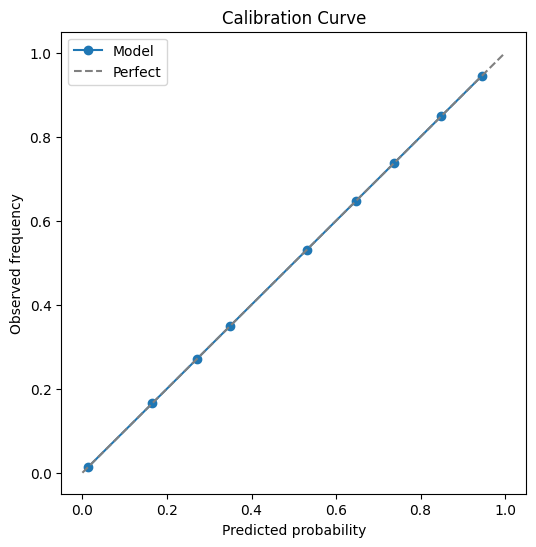

Global metrics:
{'ROC_AUC': np.float64(0.943198439874668), 'PR_AUC': np.float64(0.8800777148724096), 'Brier': np.float64(0.08734969294399758)}


In [57]:
metrics = gam_performance_report(
    df_with_probs, proba_col="proba_gam", presence_col="orca_present"
)

print("Global metrics:")
print(metrics)

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, brier_score_loss, roc_auc_score
import pandas as pd


def weekly_performance(cv_results):
    """
    Compute weekly PR-AUC, ROC-AUC, and Brier score from CV results.

    Parameters
    ----------
    cv_results : pd.DataFrame
        Must have columns 'YEAR_WEEK', 'y_true', 'y_pred'

    Returns
    -------
    weekly_metrics : pd.DataFrame
        Columns: 'YEAR_WEEK', 'PR_AUC', 'ROC_AUC', 'Brier'
    """
    weekly_metrics = (
        cv_results.groupby("YEAR_WEEK")
        .apply(
            lambda g: pd.Series(
                {
                    "PR_AUC": average_precision_score(g["y_true"], g["y_pred"]),
                    "ROC_AUC": (
                        roc_auc_score(g["y_true"], g["y_pred"])
                        if len(set(g["y_true"])) > 1
                        else float("nan")
                    ),
                    "Brier": brier_score_loss(g["y_true"], g["y_pred"]),
                }
            )
        )
        .reset_index()
    )

    # # Plotting
    # plt.figure(figsize=(12, 5))
    # plt.plot(
    #     weekly_metrics["YEAR_WEEK"],
    #     weekly_metrics["PR_AUC"],
    #     marker="o",
    #     label="PR-AUC",
    # )
    # plt.plot(
    #     weekly_metrics["YEAR_WEEK"],
    #     weekly_metrics["ROC_AUC"],
    #     marker="s",
    #     label="ROC-AUC",
    # )
    # plt.plot(
    #     weekly_metrics["YEAR_WEEK"], weekly_metrics["Brier"], marker="x", label="Brier"
    # )
    # plt.xticks(rotation=45)
    # plt.xlabel("YEAR_WEEK")
    # plt.ylabel("Metric")
    # plt.title("Weekly GAM Performance (Blocked Spatiotemporal CV)")
    # plt.legend()
    # plt.show()

    return weekly_metrics

In [60]:
weekly_metrics = weekly_performance(cv_results)

In [61]:
weekly_metrics["WEEK_"] = weekly_metrics["YEAR_WEEK"].str.split("-").str[-1]
weekly_metrics["WEEK_"] = weekly_metrics["WEEK_"].astype(int)
weekly_metrics = weekly_metrics.sort_values("WEEK_")
weekly_metrics = weekly_metrics.reset_index(drop=True)

In [62]:
import plotly.express as px
import pandas as pd


# First, assign seasons based on week number
def week_to_season(week):
    if 0 <= week <= 13:
        return "Winter"
    elif 14 <= week <= 26:
        return "Spring"
    elif 27 <= week <= 39:
        return "Summer"
    elif 40 <= week <= 53:
        return "Fall"
    else:
        return "Unknown"


weekly_metrics["Season"] = weekly_metrics["WEEK_"].apply(week_to_season)

# Compute seasonal medians
season_medians = weekly_metrics.groupby("Season")["PR_AUC"].median().reset_index()

# Boxplot with seasonal median lines
fig = px.box(weekly_metrics, x="WEEK_", y="PR_AUC", color="Season")  # , points='all')

# # Add median lines per season
# for _, row in season_medians.iterrows():
#     fig.add_hline(
#         y=row['PR_AUC'],
#         line_dash='dash',
#         line_color='black',
#         annotation_text=f"{row['Season']} median",
#         annotation_position="top left"
#     )

fig.update_layout(
    title="Weekly PR-AUC with Seasonal Medians",
    xaxis_title="Week of Year",
    yaxis_title="PR-AUC",
    template="plotly_white",
)


fig.show()

In [ ]:
# What week of the year is it?

In [43]:
season_medians

,Season,PR_AUC
0,Fall,0.430425
1,Spring,0.700000
2,Summer,0.849077
3,Winter,0.281604


In [ ]:
weekly_metrics[weekly_metrics.Season == "Unknown"]

,YEAR_WEEK,PR_AUC,ROC_AUC,Brier,WEEK_,Season
1859,2012-53,0.503911,0.927875,0.051415,53,Unknown


In [ ]:
from sklearn.isotonic import IsotonicRegression

y_true = df_with_probs["orca_present"].values
y_prob = df_with_probs["proba_gam"].values

ir = IsotonicRegression(out_of_bounds="clip")
y_prob_cal = ir.fit_transform(y_prob, y_true)

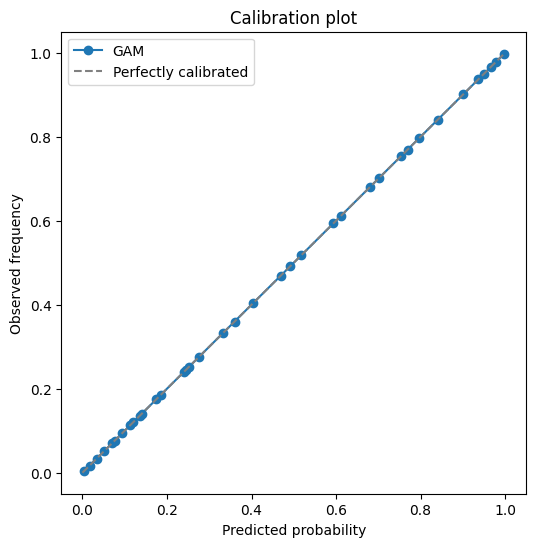

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# y_true: observed presence (0/1)
# y_prob: predicted probability


prob_true, prob_pred = calibration_curve(
    y_true, y_prob_cal, n_bins=100, strategy="uniform"
)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="GAM")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration plot")
plt.legend()
plt.show()

In [ ]:
# Approximate lat/lon bounds
min_lat, max_lat = 47.0, 50.0  # Southern Puget Sound to northern Strait of Georgia
min_lon, max_lon = -125.5, -120.5  # West to east bounds

# Create a simple polygon from bbox
from shapely.geometry import box

bbox_poly = box(min_lon, min_lat, max_lon, max_lat)

import h3

# H3 expects geo_json-like format for polyfill
bbox_geojson = {"type": "Polygon", "coordinates": [list(bbox_poly.exterior.coords)]}

# Fill H3 cells at resolution 5
h3_cells = list(h3.geo_to_cells(bbox_geojson, 7))

In [ ]:
import numpy as np
import pandas as pd
import h3
from shapely.geometry import Polygon
import geopandas as gpd


# 2. Target season (e.g., DOY 180–270 for summer)
do_list = np.arange(180, 271)

# 3. Create prediction DataFrame
pred_list = []
for DOY in do_list:
    MONTH = ((DOY - 1) // 30) + 1  # rough month
    for h in h3_cells:
        lat, lon = h3.cell_to_latlng(h)
        pred_list.append(
            {
                "H3_CELL": h,
                "LATITUDE": lat,
                "LONGITUDE": lon,
                "DOY": DOY,
                "MONTH": MONTH,
                "DOY_SIN": np.sin(2 * np.pi * DOY / 365.25),
                "DOY_COS": np.cos(2 * np.pi * DOY / 365.25),
                "MONTH_SIN": np.sin(2 * np.pi * MONTH / 12),
                "MONTH_COS": np.cos(2 * np.pi * MONTH / 12),
            }
        )

pred_df = pd.DataFrame(pred_list)

X_pred = pred_df[
    ["LATITUDE", "LONGITUDE", "DOY_SIN", "DOY_COS", "MONTH_SIN", "MONTH_COS"]
].values

# Raw GAM probabilities
y_prob_raw = gam_model.predict_proba(X_pred)

# Apply isotonic recalibration
y_prob_cal = y_prob_raw  # ir_full.transform(y_prob_raw)

pred_df["proba_gam"] = y_prob_cal

In [114]:
def h3_to_polygon(h):
    boundary = h3.cell_to_boundary(h)

    # Swap to (lon, lat) for plotting
    boundary_lonlat = [(lon, lat) for lat, lon in boundary]
    return Polygon(boundary_lonlat)


pred_df["geometry"] = pred_df["H3_CELL"].apply(h3_to_polygon)
pred_gdf = gpd.GeoDataFrame(pred_df, geometry="geometry", crs="EPSG:4326")

In [115]:
pred_gdf = pred_gdf[pred_gdf.DOY == 231]

In [116]:
pred_gdf.explore("proba_gam", cmap="turbo").save("gam_res.html")